In [1]:
import sys
!{sys.executable} -m pip install --user -r requirements.txt

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from saxpy.znorm import znorm
from nltk import ngrams  # if nltk is not already installed then run also nltk.download()
import sax
import pickle
import warnings
warnings.filterwarnings("ignore")

## Functions used

In [5]:
def add_labels(df, test=True):
    """
    Function that adds the labels to the testset or fixes the labels in training dataset 2
    :param df: the dataframe with the signals
    :param test: if True then the testset is considered otherwise the training dataset 2
    :return: the dataframe with the labels built
    """
    df.columns = df.columns.str.lstrip()
    if test:
        df['ATT_FLAG'] = 0
        df.loc['2017-01-16 09': '2017-01-19 06', 'ATT_FLAG'] = 1
        df.loc['2017-01-30 08':'2017-02-02 00',  'ATT_FLAG'] = 1
        df.loc['2017-02-09 03': '2017-02-10 09', 'ATT_FLAG'] = 1
        df.loc['2017-02-12 01': '2017-02-13 07', 'ATT_FLAG'] = 1
        df.loc['2017-02-24 05': '2017-02-28 08', 'ATT_FLAG'] = 1
        df.loc['2017-03-10 14': '2017-03-13 21', 'ATT_FLAG'] = 1
        df.loc['2017-03-25 20': '2017-03-27 01', 'ATT_FLAG'] = 1
        y = df['ATT_FLAG']  # separate the target values
        df.drop(['ATT_FLAG'], axis=1, inplace=True)
    else:
        df.loc['2016-09-13 23': '2016-09-16 00', 'ATT_FLAG'] = 1
        df.loc['2016-09-26 11': '2016-09-27 10', 'ATT_FLAG'] = 1
        df.loc['2016-10-09 09': '2016-10-11 20', 'ATT_FLAG'] = 1
        df.loc['2016-10-29 19': '2016-11-02 16', 'ATT_FLAG'] = 1
        df.loc['2016-11-26 17': '2016-11-29 04', 'ATT_FLAG'] = 1
        df.loc['2016-12-06 07': '2016-12-10 04', 'ATT_FLAG'] = 1
        df.loc['2016-12-14 15': '2016-12-19 04', 'ATT_FLAG'] = 1
        y = df['ATT_FLAG']
        df.drop(['ATT_FLAG'], axis=1, inplace=True)
    return df, y

In [6]:
def confusion_results(predicted, true):
    """
    Function that produces the "confusion" results
    :param predicted: the predicted labels
    :param true: the true labels
    :return: the true and false positives and true and false negatives
    """
    TP, FP, TN, FN = 0, 0, 0, 0
    for p, t in zip(predicted, true):
        if p and t == 1:
            TP += 1
        elif p and t != 1:
            FP += 1
        elif not p and t == 1:
            FN += 1
        else:
            TN += 1
    return TP, FP, TN, FN

In [7]:
def uncompress_labels(compressed_data, indices):
    """
    Function that fixes the size of the results obtained from the discretization so that they are of the
    same length as the initial results. It mainly copies each "compressed" label by the length of the real
    block that it represents by checking for possible duplicate limits between consecutive blocks. If there
    are overlapping limits with different prediction then the block with the positive prediction is in favor
    :param compressed_data: the discretized series
    :param indices: the indices of the actual block that each discretized step represents
    :return: the uncompressed labels
    """
    uncompressed = []
    for i in range(len(compressed_data)):
        if i < len(compressed_data)-1:
            if indices[i][1] != indices[i+1][0]:  # if overlapping indices are discovered
                if compressed_data[i] > compressed_data[i+1]:  # then act in favor of the attack
                    indices[i + 1][0] += 1
                else:
                    indices[i][1] -= 1
        # copy the discretized label as many times as the number of time steps in the initial block
        uncompressed += [compressed_data[i]] * (indices[i][1]-indices[i][0])
    return uncompressed

In [8]:
def discretize_data(data, w, features, start_date, end_date, dataset, plotting):
    """
    Function that performs SAX discretization on the signals
    :param data: the signals to be discretized
    :param w: the number of PAA segments to represent the initial time series
    :param features: the name of the signals to be discretized
    :param start_date: date used mostly for visualization reasons
    :param end_date: date used mostly for visualization reasons
    :param dataset: the type of the dataset (used for saving reasons)
    :param plotting: if True then the discretized signals are plotted
    :return: the discretized series with the indices of each PAA segment
    """
    alphabet = 5  # the length of the alphabet to be used
    # dictionaries used for plotting reasons
    symbol_to_number = {'a': -1.5, 'b': -0.75, 'c': 0, 'd': 0.75, 'e': 1.5}
    number_to_symbol = {'0': 'a', '1': 'b', '2': 'c', '3': 'd', '4': 'e'}
    sax_seqs = {}
    sax_indices = {}
    for feature in features:
        print('------------------------------------- Discretizing %s -------------------------------------' % feature)
        sax_str, real_indices = sax.to_letter_rep(np.array(data[feature]), w, alphabet)  # SAX discretization
        sax_seqs[feature] = sax_str  # store the discretized series
        sax_indices[feature] = real_indices  # store the indices of the real blocks

        # plotting part
        if plotting:
            normalized_signal = znorm(np.array(data[feature]))
            discrete = uncompress_labels(sax_str, real_indices)
            discrete = [symbol_to_number[number_to_symbol[d]] for d in discrete]

            fig = plt.figure()
            ax = fig.add_subplot(111)
            ax.plot(pd.DataFrame(normalized_signal, index=data.index).loc[start_date:end_date],
                    label='normalized signal')
            ax.plot(pd.DataFrame(discrete, index=data.index).loc[start_date:end_date], label='discretized signal')
            ax.xaxis.set_major_locator(mdates.DayLocator([5, 10, 15, 20, 25, 30]))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
            plt.xlabel("time")
            plt.ylabel(feature)
            plt.xticks(rotation=45)
            plt.yticks(np.array(list(symbol_to_number.values())), tuple(symbol_to_number.keys()))
            plt.grid()
            plt.legend(loc='lower right')
#             plt.savefig('plots/sax/%s_discretization_%s.png' % (dataset, feature), bbox_inches='tight')
            plt.show()
    return sax_seqs, sax_indices

In [9]:
def train_ngram(dsc_train, w):
    """
    Function that is used to calculate the probabilities of each transition in the discretized series given a
    sliding window
    :param dsc_train: the training discretized sequence
    :param w: the length of the window
    :return: a dictionary keyed by the transitions present in the training sequence and valued with the
    frequencies of appearance of  these transitions
    """

    states = {}

    # get the ngrams of length w for the training data
    all_ngrams = ngrams(dsc_train, w)
    cnt = 0.0  # counter used to count the number of transitions in the dataset
    prev = ""  # previous state
    try:
        while True:
            # get the next gram
            gram = next(all_ngrams)

            # create the key through the transition
            curr = ''.join(gram)
            key = prev + '-' + curr

            # check if the transition already existed
            states[key] = states[key] + 1 if key in states.keys() else 1

            cnt += 1
            # store the old key
            prev = curr
    except StopIteration:
        pass

    # calculate the frequencies
    for key in states.keys():
        states[key] = states[key] / cnt

    return states

In [10]:
def test_ngram(dsc_test, w, threshold, states, states1):
    """
    Function that is used to calculate the labels on the discretized dataset
    :param dsc_test: the discretized testset
    :param w: the length of the sliding window
    :param threshold: the threshold under which the frequency of a transition is thought to be associated
     with an attack
    :param states: the states of the normal training set 1
    :param states1: the states of the training set 2 that contained also attacks
    :return: the predicted labels for the discretized dataset
    """

    # get the ngrams of length w for the test data
    test_grams = ngrams(dsc_test, w)
    prev = ""
    anomalies = []

    try:
        while True:
            # get the next gram
            gram = next(test_grams)

            # create the transition key
            curr = ''.join(gram)
            key = prev + '-' + curr

            # check the probabilities of this transition
            if prev == "":  # if there is no transition so far then no attack
                anomalies += [0]
            # if the transition wasn't seen in both of the training datasets then mark it as an attack
            elif key not in states.keys() and key not in states1.keys():
                anomalies += [1]
            # if the transition was seen in the training dataset 2 (that contained attacks) but its frequency
            # is lower than the threshold then mark it as an attack
            elif key in states1.keys() and states1[key] < threshold:
                anomalies += [1]
            # in any other case no attack is detected
            else:
                anomalies += [0]

            # store the old key
            prev = curr
    except StopIteration:
        pass

    return anomalies + [0]  # padding added to match the length of the initial discretized sequence


In [11]:
def plot_anomalies(true_anomalies, predicted_anomalies, sensor):
    """
    Function that plots the predicted attacks against the true attacks
    :param true_anomalies: the true labels
    :param predicted_anomalies: the predicted labels
    :param sensor: either the name of one sensor or the strings 'all' or 'considered' are used when more than
    one sensors are to be considered
    :return: creates the anomaly plots
    """
    if sensor == 'considered' or sensor == 'all':  # if more than one sensors are considered
        final_predictions = np.array([0]*len(true_anomalies))
        for pred in predicted_anomalies.values():  # first merge the predictions
            final_predictions = final_predictions | np.array(pred)

        # and now plot them
        fig, ax = plt.subplots()
        ax.fill_between(true_anomalies.index, true_anomalies, label='True', alpha=0.5)
        ax.fill_between(true_anomalies.index, list(final_predictions), label='Predicted', alpha=0.5)
        ax.xaxis.set_major_locator(mdates.DayLocator([5, 10, 15, 20, 25, 30]))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
        ax.set_ylabel('Attacks')
        ax.grid()
        plt.legend()
        plt.title('Attacks for {} sensors'.format(sensor))
        plt.xticks(rotation=45)
        plt.xlabel("Date")
#         plt.savefig('plots/ngrams/attacks_%s.png' % sensor, bbox_inches='tight')
        plt.show()
        TP, FP, TN, FN = confusion_results(final_predictions, list(true_anomalies))
        print('------------------- Total Test results -------------------')
        print('TP: %d, FP: %d, TN: %d, FN: %d' % (TP, FP, TN, FN))
    else:
        fig, ax = plt.subplots()
        ax.fill_between(true_anomalies.index, true_anomalies, label='True', alpha=0.5)
        ax.fill_between(true_anomalies.index, predicted_anomalies, label='Predicted', alpha=0.5)
        ax.xaxis.set_major_locator(mdates.DayLocator([5, 10, 15, 20, 25, 30]))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
        ax.set_ylabel('Attacks')
        ax.grid()
        plt.legend()
        plt.title('Attacks for sensor {}'.format(sensor))
        plt.xticks(rotation=45)
        plt.xlabel("Date")
#         plt.savefig('plots/ngrams/attacks_%s.png' % sensor, bbox_inches='tight')
        plt.show()

## Read the datasets

In [12]:
# read the datasets
print('Reading datasets...')
train_df1 = pd.read_csv('BATADAL_datasets/BATADAL_training_dataset1.csv', index_col=0, parse_dates=[0],
                        date_parser=lambda x: pd.to_datetime(x, format="%d/%m/%y %H"))

train_df2 = pd.read_csv('BATADAL_datasets/BATADAL_training_dataset2.csv', index_col=0, parse_dates=[0],
                        date_parser=lambda x: pd.to_datetime(x, format="%d/%m/%y %H"))
train_df2, train2_anomalies = add_labels(train_df2, test=False)

test_df = pd.read_csv('BATADAL_datasets/BATADAL_test_dataset.csv', index_col=0, parse_dates=[0],
                      date_parser=lambda x: pd.to_datetime(x, format="%d/%m/%y %H"))
test_df, true_anomalies = add_labels(test_df)

Reading datasets...


## Discretize the data with SAX

In [13]:
# discretize the data
print('Discretizing the data with SAX...')
# all of the sensors are here
# ['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7', 'F_PU1', 'F_PU2', 'F_PU3', 'F_PU4', 'F_PU5', 'F_PU6',
# 'F_PU7', 'F_PU8', 'F_PU9', 'F_PU10', 'F_PU11', 'F_V2', 'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415',
# 'P_J302', 'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422']
print('Training set 1...')
dsc_sensors, dsc_indices = discretize_data(train_df1, 500, ['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7',
                                                            'F_PU1', 'F_PU2', 'F_PU3', 'F_PU4', 'F_PU5', 'F_PU6',
                                                            'F_PU7', 'F_PU8', 'F_PU9', 'F_PU10', 'F_PU11', 'F_V2',
                                                            'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289',
                                                            'P_J415', 'P_J302', 'P_J306', 'P_J307', 'P_J317',
                                                            'P_J14', 'P_J422'], '2014-09-01', '2014-09-30',
                                           'train1', False)
print('Training set 2...')
dsc_sensors_tr2, dsc_indices_tr2 = discretize_data(train_df2, 250, ['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6',
                                                                    'L_T7', 'F_PU1', 'F_PU2', 'F_PU3', 'F_PU4',
                                                                    'F_PU5', 'F_PU6', 'F_PU7', 'F_PU8', 'F_PU9',
                                                                    'F_PU10', 'F_PU11', 'F_V2', 'P_J280', 'P_J269',
                                                                    'P_J300', 'P_J256', 'P_J289', 'P_J415',
                                                                    'P_J302', 'P_J306', 'P_J307', 'P_J317', 'P_J14',
                                                                    'P_J422'], '2016-07-04', '2016-07-30', 'train2',
                                                   False)
print('Test set 1...')
dsc_sensors_tst, dsc_indices_tst = discretize_data(test_df, 125, ['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6',
                                                                  'L_T7', 'F_PU1', 'F_PU2', 'F_PU3', 'F_PU4',
                                                                  'F_PU5', 'F_PU6', 'F_PU7', 'F_PU8', 'F_PU9',
                                                                  'F_PU10', 'F_PU11', 'F_V2', 'P_J280', 'P_J269',
                                                                  'P_J300', 'P_J256', 'P_J289', 'P_J415', 'P_J302',
                                                                  'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422'],
                                                   '2017-01-04', '2017-01-30', 'test', False)

Discretizing the data with SAX...
Training set 1...
------------------------------------- Discretizing L_T1 -------------------------------------
------------------------------------- Discretizing L_T2 -------------------------------------
------------------------------------- Discretizing L_T3 -------------------------------------
------------------------------------- Discretizing L_T4 -------------------------------------
------------------------------------- Discretizing L_T5 -------------------------------------
------------------------------------- Discretizing L_T6 -------------------------------------
------------------------------------- Discretizing L_T7 -------------------------------------
------------------------------------- Discretizing F_PU1 -------------------------------------
------------------------------------- Discretizing F_PU2 -------------------------------------
------------------------------------- Discretizing F_PU3 -------------------------------------
-----

## Computing N-grams and plotting the results
#### In this version the results for all sensors are presented in a merged way. If you want to use less sensors just change the sensors that are discretized in the above cell

N-gram calculation...
------------------------------------- Training on L_T1 -------------------------------------
------------------------------------- Training on L_T2 -------------------------------------
------------------------------------- Training on L_T3 -------------------------------------
------------------------------------- Training on L_T4 -------------------------------------
------------------------------------- Training on L_T5 -------------------------------------
------------------------------------- Training on L_T6 -------------------------------------
------------------------------------- Training on L_T7 -------------------------------------
------------------------------------- Training on F_PU1 -------------------------------------
------------------------------------- Training on F_PU2 -------------------------------------
------------------------------------- Training on F_PU3 -------------------------------------
------------------------------------- Trainin

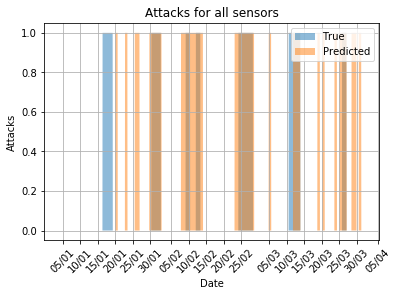

In [14]:
# n-grams part
print('N-gram calculation...')
ngram_results = {}
for sensor in dsc_sensors.keys():
    print('------------------------------------- Training on %s -------------------------------------' % sensor)
    # first calculate the probabilities for the transitions in the no-anomaly dataset
    states = train_ngram(dsc_sensors[sensor], 2)
    # then calculate the probabilities for the transitions in the anomalies-including training dataset
    states_1 = train_ngram(dsc_sensors_tr2[sensor], 2)
    # set the threshold as the minimum frequency recorded in training dataset 1
    threshold = min(states.values())
    # predict the anomalies on the testset
    anomalies = test_ngram(dsc_sensors_tst[sensor], 2, threshold, states, states_1)
    # store the reconstructed series with the predicted labels
    ngram_results[sensor] = uncompress_labels(anomalies, dsc_indices_tst[sensor])
    TP, FP, TN, FN = confusion_results(ngram_results[sensor], list(true_anomalies))
    # print('------------------- Test results -------------------')
    # print('TP: %d, FP: %d, TN: %d, FN: %d' % (TP, FP, TN, FN))
# plot the results
plot_anomalies(true_anomalies, ngram_results, 'all')
# with open('discrete_all.pickle', 'wb') as handle:
#     pickle.dump(ngram_results, handle, protocol=pickle.HIGHEST_PROTOCOL)